# Decision Trees

## In this notebook we will perform the following:
1. Implement two impurity measures: Gini and Entropy.
2. Construct a decision tree algorithm.
3. Prune the tree to achieve better results.
4. Visualize your results.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Our desicion tree will be implemented using a dedicated python class.

In [61]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [62]:
# load dataset
data = pd.read_csv('data/agaricus-lepiota.csv')
data.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [63]:
# Find the columns with missing values and remove them from the data.
data.drop([col for col in data.columns if data[col].isnull().any()], axis='columns', inplace=True)

# # Remove missing data
# data.dropna(inplace=True)

We will split the dataset to `Training` and `Testing` datasets.

In [64]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [65]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [66]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
    
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    unique, counts = np.unique(data[:,-1], return_counts=True)
    d = dict(zip(unique,counts))
    number_of_samples = counts.sum()
    gini = 1.0
    
    for key in unique:
        gini -= (d.get(key) / number_of_samples) ** 2

    return gini

calc_gini(X)

0.49956363223797745

In [67]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    unique, counts = np.unique(data[:,-1], return_counts=True)
    d = dict(zip(unique,counts))
    number_of_samples = counts.sum()
    
    for key in unique:
        entropy += (d.get(key) / number_of_samples) * np.log2(d.get(key) / number_of_samples)
    entropy *= -1

    return entropy

In [68]:
# Test the functions
calc_gini(X), calc_entropy(X)

(0.49956363223797745, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio. You'll control the return value with the `gain_ratio` parameter.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$

In [69]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False, using_entrophy=True):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    atribute_column = data[:,feature]
    unique, counts = np.unique(atribute_column, return_counts=True)
    d = dict(zip(unique,counts))
    information_gain = impurity_func(data)
    ## for ratio computation
    split_information = 0.0 if using_entrophy else 1.0
    s_size = counts.sum()
    
    for key in unique:
        temp_data = data[data[:,feature] == key]
        p_i = d.get(key)/s_size
        information_gain -= p_i * impurity_func(temp_data)
        
    ## for ratio computation
    split_information -= p_i * np.log2(p_i) if using_entrophy else p_i**2
    
    goodness = information_gain / split_information if gain_ratio else information_gain
    
    return goodness

## Building a Decision Tree

In [70]:
class DecisionNode:
    def __init__(self, feature):
        self.feature = feature # column index of criteria being tested
        self.children = []
        self.pred = None
        self.my_value = None
        self.father = None
        self.count = None
        self.e_count = 0
        self.p_count = 0
        
    def add_child(self, node):
        self.children.append(node)
        
    def isLeaf(self):
        return self.children == []
    
    def tree_depth(self):
        depth_list = []
        if not self.children:
            return 0
        
        for child in self.children:
            depth_list.append(child.tree_depth())
            
        return max(depth_list) + 1

In [71]:
def build_tree(data, impurity, gain_ratio=False, chi=1, max_depth=1000, my_value = None, feature_list=[-1],father = None):
    """
    Build a tree using the given impurity measure and training dataset. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure.
    - gain_ratio: goodness of split or gain ratio flag
    - chi: chi square p-value cut off (1 means no pruning)
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = DecisionNode(-1)
    ## calculate pred
    last_col = data[:,-1]
    unique, counts = np.unique(last_col, return_counts=True)
    d = dict(zip(unique,counts))
    root.pred = max(d, key=d.get)
    root.count = d.get(root.pred)
    root.my_value = my_value
    root.father = father
    root.e_count = d.get('e') if d.get('e') else 0
    root.p_count = d.get('p') if d.get('p') else 0

    if max_depth <= 0 or impurity(data) == 0 or len(data) <=0:
        return root
    
    if(feature_list[0] == -1):
        feature_list = np.arange(len(data[0])-1)
    ##find best feature
    best_goodness = 0.0
    best_feature = feature_list[0]
    for feature_index in feature_list:
        temp_goodness = goodness_of_split(data, feature_index, impurity, gain_ratio, using_entrophy= impurity == calc_entropy)
        if(temp_goodness > best_goodness):
            best_goodness = temp_goodness
            best_feature = feature_index
    
    ##chi test
    if(chi != 1):
        ##calculate chi test
        chi_square = 0.0
        P_0 = d.get('e') / counts.sum()
        P_1 = d.get('p') / counts.sum()
        
        feature_col = data[:, best_feature]
        unique = np.unique(feature_col)
        
        for value in unique:
            temp = data[data[:,best_feature] == value]
            intances_e = temp[temp[:,-1] == 'e']
            d_f = len(temp)
            p_f = len(intances_e)
            n_f = d_f - p_f
            E_0 = d_f * P_0
            E_1 = d_f * P_1
            chi_square += ((p_f-E_0)**2) / E_0   +   ((n_f-E_1)**2) / E_1
            
        #end for loop
        d_of_freedom = len(unique) - 1 
        if d_of_freedom > 0 and chi_square <= chi_table[d_of_freedom][chi]:
            return root
    
    root.feature = best_feature
    feature_col = data[:, best_feature]
    unique = np.unique(feature_col)
    
    feature_list = np.delete(feature_list, np.where(feature_list == best_feature), axis=0)
    ## adding childs
    for value in unique:
        temp_data = data[data[:,best_feature] == value]
        root.add_child(build_tree(temp_data, impurity, gain_ratio, chi, max_depth-1, value, feature_list.copy(), root))
        
    return root

In [72]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

In [73]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    
    while(node.children != []):
        found = False
        value = instance[node.feature]
        for c in node.children:
            if c.my_value == value:
                found = True
                node = c
                break
        if(found == False):
            break

    return node.pred   

In [74]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0.0
    suc_count = 0
    
    for i in range(len(dataset)):
        line = dataset[i]
        if predict(node, line) == line[-1]:
            suc_count += 1
            
    accuracy = suc_count * 100 / len(dataset) 

    return accuracy 

After building the three trees using the training set, we should calculate the accuracy on the test set. For each tree we print the training and test accuracy. Selecting the tree that gave us the best test accuracy. For the rest of the notebook, we use that tree. 

In [75]:
gini_X_train = calc_accuracy(tree_gini, X_train)
gini_X_test = calc_accuracy(tree_gini, X_test)

entropy_X_train = calc_accuracy(tree_entropy, X_train)
entropy_X_test = calc_accuracy(tree_entropy, X_test)

entropy_gain_ratio_X_train = calc_accuracy(tree_entropy_gain_ratio, X_train)
entropy_gain_ratio_X_test = calc_accuracy(tree_entropy_gain_ratio, X_test)


print("accuracy of tree_gini with X_train: ", gini_X_train,"%")
print("accuracy of tree_gini with X_test: ", gini_X_test,"%")

print("accuracy of tree_entropy with X_train: ", entropy_X_train,"%")
print("accuracy of tree_entropy with X_test: ", entropy_X_test,"%")

print("accuracy tree_entropy_gain_ratio with X_train: ", entropy_gain_ratio_X_train,"%")
print("accuracy of tree_entropy_gain_ratio X_test: ", entropy_gain_ratio_X_test,"%")


## remember best tree model
best_tree = tree_gini
min_val = gini_X_test

if(min_val < entropy_X_test):
    min_val=entropy_X_test
    best_tree = tree_entropy
    
if(min_val < entropy_gain_ratio_X_test):
    best_tree = tree_entropy_gain_ratio

accuracy of tree_gini with X_train:  100.0 %
accuracy of tree_gini with X_test:  77.35105859182669 %
accuracy of tree_entropy with X_train:  100.0 %
accuracy of tree_entropy with X_test:  77.10487444608567 %
accuracy tree_entropy_gain_ratio with X_train:  100.0 %
accuracy of tree_entropy_gain_ratio X_test:  78.43426883308715 %


## Number of Nodes

In [76]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    if node.isLeaf():
        return 1
    else:
        count = 1
        for c in node.children:
            count += count_nodes(c)
        return count    

## Post pruning

We iterate over all nodes in the tree that have at least a single child which is a leaf. For each such node, we replace it with its most popular class. Calculate the accuracy on the testing dataset, pick the node that results in the highest testing accuracy and permanently change it in the tree. Repeat this process until you are left with a single node in the tree (the root). Finally, we create a plot of the training and testing accuracies as a function of the number of nodes in the tree.

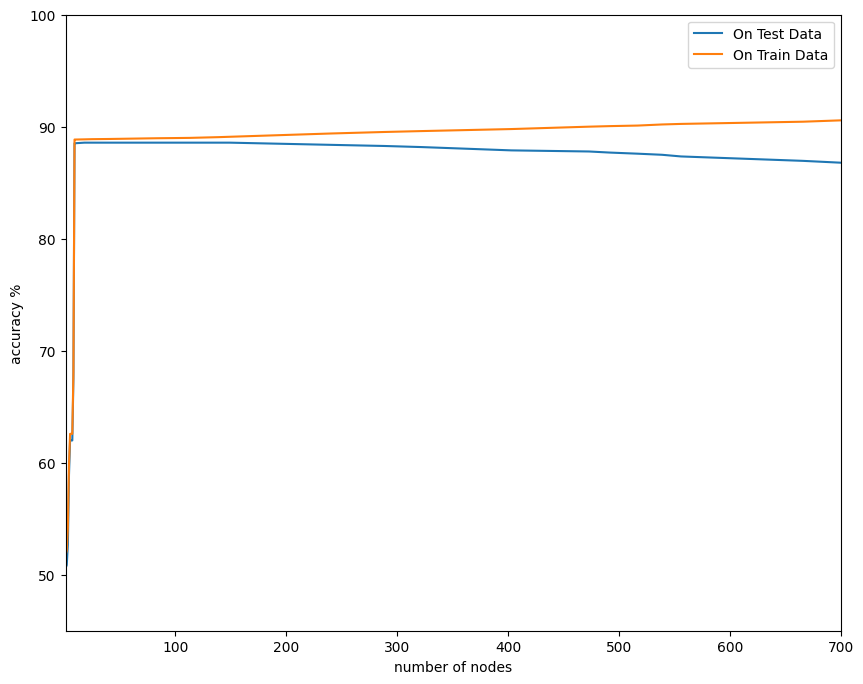

In [77]:
def helper(tree):
    node = tree
    stop = False
    for child in node.children:
        if child.isLeaf():
            stop = True
            break
    if stop and node.father != None:
        recursive_list = [node]
    else:
        recursive_list = []
    for child in node.children:
        recursive_list += helper(child)
    return recursive_list
    

def post_pruning(tree, data_test, data_train, return_best_flag=False):
    ##variables for plotting
    num_of_node = [count_nodes(tree)]
    accuracy_list = [calc_accuracy(tree, data_test)]
    accuracy_list_on_train = [calc_accuracy(tree, data_train)]
    best_tree = tree
    best_tree_acc = calc_accuracy(tree, data_test)
    
    list_nodes = helper(tree)
    best_acc = 0.0
    if len(list_nodes) > 0:
        node_to_prun = list_nodes[0]
        node_to_prun_father = list_nodes[0].father
    
    
    while len(list_nodes) > 0:
        for node in list_nodes:
            ##init pure node for replacment
            pure_node = DecisionNode(-1)
            pure_node.children = []
            pure_node.pred = node.pred
            pure_node.my_value = node.my_value

            ##replace
            father = node.father
            father.children.remove(node)
            father.children.append(pure_node)
            pure_node.father = father

            ##calc accuracy
            temp_acc = calc_accuracy(tree, data_test)
            if(temp_acc > best_acc):
                best_acc = temp_acc
                node_to_prun = node
                node_to_prun_father = father

            ##return node
            father.children.remove(pure_node)
            father.children.append(node)

        #end for loop
        ##prun the chosen node from tree
        pure_node = DecisionNode(-1)
        pure_node.children = []
        pure_node.pred = node_to_prun.pred
        pure_node.father = node_to_prun_father
        pure_node.my_value = node_to_prun.my_value
        
        node_to_prun_father.children.remove(node_to_prun)
        node_to_prun_father.children.append(pure_node)
        
        # update best tree
        if return_best_flag and best_acc < best_tree_acc:
            return num_of_node , accuracy_list, accuracy_list_on_train
        
        # for plotting
        num_of_node.append(count_nodes(tree))
        accuracy_list.append(best_acc)
        accuracy_list_on_train.append(calc_accuracy(tree, data_train))
        
        
        #update list of node
        list_nodes = helper(tree)
        best_acc = 0.0
        if len(list_nodes) > 0:
            node_to_prun = list_nodes[0]
            node_to_prun_father = list_nodes[0].father
        else: 
            break

    # at this point there is a root and few leafs removing leaf by leaf from the root
    while tree.children != []:
        tree.children.pop(0)
        num_of_node.append(count_nodes(tree))
        accuracy_list.append(calc_accuracy(tree, data_test))
        accuracy_list_on_train.append(calc_accuracy(tree, data_train))    
    
    # results with only 1 node  
    num_of_node.append(count_nodes(tree))
    accuracy_list.append(calc_accuracy(tree, data_test))
    accuracy_list_on_train.append(calc_accuracy(tree, data_train))
    
    return num_of_node , accuracy_list, accuracy_list_on_train
    

    
## plotting 
num_of_node, accuracy_list, accuracy_list_on_train = post_pruning(tree_gini, X_test, X_train)
plt.xlabel("number of nodes")
plt.ylabel("accuracy %")
plt.plot(num_of_node, accuracy_list,   label= "On Test Data")
plt.plot(num_of_node, accuracy_list_on_train,  label= "On Train Data")
plt.axis([1, 700, 45, 100])
plt.legend()
plt.show()

#reconstruct tree
tree_gini = build_tree(data=X_train, impurity=calc_gini)

## Chi square pre-pruning

Consider the following p-value cut-off values: [1 (no pruning), 0.5, 0.25, 0.1, 0.05, 0.0001 (max pruning)]. For each value, construct a tree and prune it according to the cut-off value. Next, calculate the training and testing accuracy. On a single plot, draw the training and testing accuracy as a function of the tuple (p-value, tree depth). Mark the best result on the graph with red circle. (15 points)

In [78]:
### Chi square table values ###
# The first key is the degree of freedom 
# The second key is the p-value cut-off
# The values are the chi-statistic that you need to use in the pruning
chi_table = {1: {0.5 : 0.45,
                 0.25 : 1.32,
                 0.1 : 2.71,
                 0.05 : 3.84,
                 0.0001 : 100000},
             2: {0.5 : 1.39,
                 0.25 : 2.77,
                 0.1 : 4.60,
                 0.05 : 5.99,
                 0.0001 : 100000},
             3: {0.5 : 2.37,
                 0.25 : 4.11,
                 0.1 : 6.25,
                 0.05 : 7.82,
                 0.0001 : 100000},
             4: {0.5 : 3.36,
                 0.25 : 5.38,
                 0.1 : 7.78,
                 0.05 : 9.49,
                 0.0001 : 100000},
             5: {0.5 : 4.35,
                 0.25 : 6.63,
                 0.1 : 9.24,
                 0.05 : 11.07,
                 0.0001 : 100000},
             6: {0.5 : 5.35,
                 0.25 : 7.84,
                 0.1 : 10.64,
                 0.05 : 12.59,
                 0.0001 : 100000},
             7: {0.5 : 6.35,
                 0.25 : 9.04,
                 0.1 : 12.01,
                 0.05 : 14.07,
                 0.0001 : 100000},
             8: {0.5 : 7.34,
                 0.25 : 10.22,
                 0.1 : 13.36,
                 0.05 : 15.51,
                 0.0001 : 100000},
             9: {0.5 : 8.34,
                 0.25 : 11.39,
                 0.1 : 14.68,
                 0.05 : 16.92,
                 0.0001 : 100000},
             10: {0.5 : 9.34,
                  0.25 : 12.55,
                  0.1 : 15.99,
                  0.05 : 18.31,
                  0.0001 : 100000},
             11: {0.5 : 10.34,
                  0.25 : 13.7,
                  0.1 : 17.27,
                  0.05 : 19.68,
                  0.0001 : 100000}}

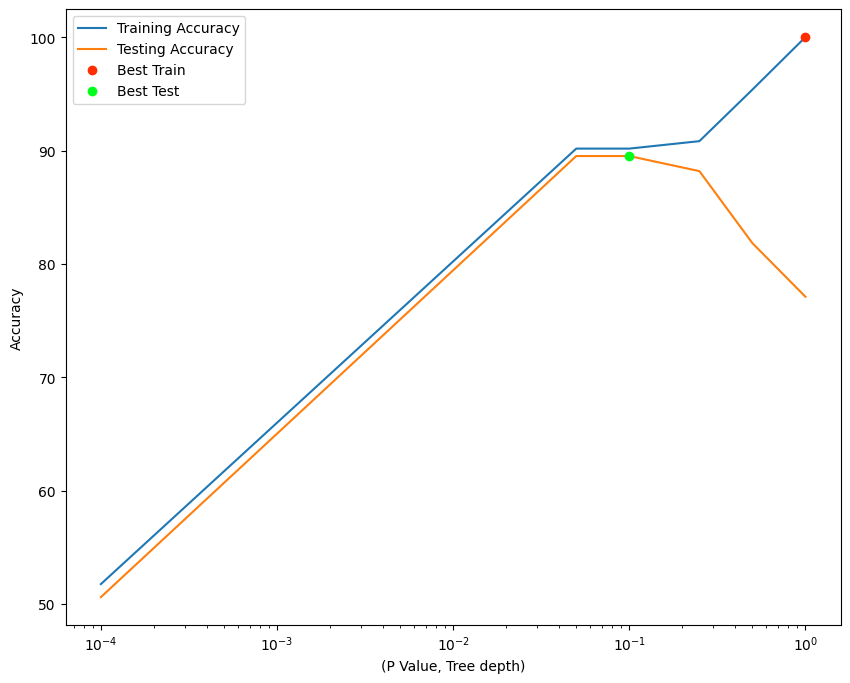

In [80]:
p_values = [1, 0.5, 0.25, 0.1, 0.05, 0.0001]
training, testing, x_values = [], [], []

for p_value in p_values:
    # TODO: check which func to send and gain_ratio True\False
    tree = build_tree(X_train, calc_entropy, gain_ratio=False, chi=p_value)
    training.append(calc_accuracy(tree, X_train))
    testing.append(calc_accuracy(tree, X_test))
    x_values.append((p_value, tree.tree_depth()))

train_max = max(training)
test_max = max(testing)
chi_max_train = p_values[training.index(train_max)]
chi_max_test = p_values[testing.index(test_max)]

plt.xticks(p_values, x_values)
plt.xlabel('(P Value, Tree depth)')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.plot(p_values, training, label='Training Accuracy')
plt.plot(p_values, testing, label='Testing Accuracy')
plt.plot(chi_max_train, train_max, 'o', color="#FF2D00", label='Best Train')
plt.plot(chi_max_test, test_max, 'o', color="#00FF1A", label="Best Test")
plt.legend()
plt.show()


Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_chi - the best tree according to chi square pruning

In [81]:
best_tree_chi = build_tree(X_train, calc_entropy, gain_ratio=False, chi=chi_max_test)
best_tree_post_prunning = post_pruning(best_tree, X_test, X_train, return_best_flag=True)

## Print the tree
Example of a tree:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node.
* The second argument is the selected feature of the current node.

In [83]:
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree
    '''
    # print indentation
    for space in range(depth):
        print(' ',end='')
    
    if not node.isLeaf():
        if parent_feature == 'ROOT':
            print('[{}, Feature=X{}],'.format(parent_feature, node.feature))
            
        else:
            print('[X{}={}, Feature=X{}],'.format(parent_feature, node.my_value, node.feature))
            
        for child in node.children:
            print_tree(child, depth + 1, node.feature, child.feature)
    else:
        if node.e_count > 0 and node.p_count > 0:
            print("[X{}={}, leaf]: [e: {}, p: {}]".format(parent_feature, node.my_value, node.e_count, node.p_count))
        else:
            if node.e_count > 0:
                print("[X{}={}, leaf]: [e: {}]".format(parent_feature, node.my_value, node.e_count))
            else:
                print("[X{}={}, leaf]: [p: {}]".format(parent_feature, node.my_value, node.p_count))


In [85]:
# Print the best tree
print_tree(best_tree_chi)

[ROOT, Feature=X4],
 [X4=a, leaf]: [e: 273, p: 31]
 [X4=c, leaf]: [e: 10, p: 137]
 [X4=f, leaf]: [e: 170, p: 1438]
 [X4=l, Feature=X1],
  [X1=f, leaf]: [e: 19, p: 1]
  [X1=s, leaf]: [e: 94, p: 16]
  [X1=y, leaf]: [e: 159, p: 10]
 [X4=m, leaf]: [e: 2, p: 25]
 [X4=n, Feature=X18],
  [X18=b, leaf]: [e: 34, p: 2]
  [X18=h, Feature=X2],
   [X2=r, leaf]: [e: 9, p: 4]
   [X2=u, leaf]: [e: 14]
   [X2=w, leaf]: [e: 12, p: 1]
  [X18=k, leaf]: [e: 875, p: 96]
  [X18=n, Feature=X8],
   [X8=g, leaf]: [e: 9, p: 1]
   [X8=h, leaf]: [e: 68, p: 8]
   [X8=k, leaf]: [e: 79, p: 7]
   [X8=n, leaf]: [e: 236, p: 24]
   [X8=o, leaf]: [e: 12]
   [X8=p, Feature=X2],
    [X2=e, leaf]: [e: 45, p: 4]
    [X2=g, Feature=X1],
     [X1=f, leaf]: [e: 47]
     [X1=s, Feature=X10],
      [X10=f, leaf]: [e: 6]
      [X10=s, leaf]: [e: 2, p: 2]
     [X1=y, Feature=X13],
      [X13=g, leaf]: [e: 10]
      [X13=p, leaf]: [e: 6, p: 2]
      [X13=w, leaf]: [e: 9]
    [X2=n, leaf]: [e: 79, p: 6]
    [X2=w, leaf]: [e: 20, p: 5]